<center>
    
## Aprendizaje No Supervisado - DiploDatos
    Laura Alonso Alemany, Ana Georgina Flesia y Valeria Rulloni
## Embeddings y Agrupamiento con el FIFA 2019 dataset
    
Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros.

### Indice de temas
1. [Inicialización del entorno](#1.-Inicialización-del-entorno)
2. [Preparación de los datos](#2.-Preparación-de-los-datos)
3. [Visualizacion con embeddings:tSNE](#3.-Visualizacion-con-embeddings:tSNE)
4. [Componentes Principales](#4.-Componentes-Principales)
5. [Clustering](#5.-Clustering)


## 1.-Inicialización-del-entorno

Empezamos cargando algunas herramientas para cargar los datos y manipularlos.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

In [2]:
from sklearn import (manifold, preprocessing, decomposition)
import time

In [3]:
!pip install plotly

In [4]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

## 2.-Preparación-de-los-datos

Cargamos los datos bajados de la database de [Kaggle](https://www.kaggle.com/karangadiya/fifa19) como 'data.csv'. 

In [5]:
df=pd.read_csv("players_21.csv")
df.head()

sofifa_id                                         player_url  \
0     158023  https://sofifa.com/player/158023/lionel-messi/...   
1      20801  https://sofifa.com/player/20801/c-ronaldo-dos-...   
2     200389  https://sofifa.com/player/200389/jan-oblak/210002   
3     188545  https://sofifa.com/player/188545/robert-lewand...   
4     190871  https://sofifa.com/player/190871/neymar-da-sil...   

          short_name                            long_name  age         dob  \
0           L. Messi       Lionel Andrés Messi Cuccittini   33  1987-06-24   
1  Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro   35  1985-02-05   
2           J. Oblak                            Jan Oblak   27  1993-01-07   
3     R. Lewandowski                   Robert Lewandowski   31  1988-08-21   
4          Neymar Jr        Neymar da Silva Santos Júnior   28  1992-02-05   

   height_cm  weight_kg nationality            club_name  \
0        170         72   Argentina         FC Barcelona   
1        187         83    Portugal             Juventus   
2        188         87    Slovenia      Atlético Madrid   
3        184         80      Poland    FC Bayern München   
4        175         68      Brazil  Paris Saint-Germain   

              league_name  league_rank  overall  potential  value_eur  \
0  Spain Primera Division          1.0       93         93   67500000   
1         Italian Serie A          1.0       92         92   46000000   
2  Spain Primera Division          1.0       91         93   75000000   
3    German 1. Bundesliga          1.0       91         91   80000000   
4          French Ligue 1          1.0       91         91   90000000   

   wage_eur player_positions preferred_foot  international_reputation  \
0    560000       RW, ST, CF           Left                         5   
1    220000           ST, LW          Right                         5   
2    125000               GK          Right                         3   
3    240000               ST          Right                         4   
4    270000          LW, CAM          Right                         5   

   weak_foot  skill_moves      work_rate             body_type real_face  \
0          4            4     Medium/Low                 Messi       Yes   
1          4            5       High/Low            C. Ronaldo       Yes   
2          3            1  Medium/Medium  PLAYER_BODY_TYPE_259       Yes   
3          4            4    High/Medium  PLAYER_BODY_TYPE_276       Yes   
4          5            5    High/Medium                Neymar       Yes   

   release_clause_eur                                        player_tags  \
0         138400000.0  #Dribbler, #Distance Shooter, #FK Specialist, ...   
1          75900000.0  #Aerial Threat, #Dribbler, #Distance Shooter, ...   
2         159400000.0                                                NaN   
3         132000000.0              #Distance Shooter, #Clinical Finisher   
4         166500000.0  #Speedster, #Dribbler, #Playmaker, #FK Special...   

  team_position  team_jersey_number loaned_from      joined  \
0           CAM                10.0         NaN  2004-07-01   
1            LS                 7.0         NaN  2018-07-10   
2            GK                13.0         NaN  2014-07-16   
3            ST                 9.0         NaN  2014-07-01   
4            LW                10.0         NaN  2017-08-03   

   contract_valid_until nation_position  nation_jersey_number  pace  shooting  \
0                2021.0              RW                  10.0  85.0      92.0   
1                2022.0              LS                   7.0  89.0      93.0   
2                2023.0              GK                   1.0   NaN       NaN   
3                2023.0             NaN                   NaN  78.0      91.0   
4                2022.0             NaN                   NaN  91.0      85.0   

   passing  dribbling  defending  physic  gk_diving  gk_handling  gk_kicking  \
0     91.0       95.0       38.0

# 3.-Visualizacion-con-embeddings:tSNE

**t-SNE : t-distributed Stochastic Neighbor Embedding.**

t-SNE es una herramienta para visualizar datos altamente dimensionales. 

Los "proyecta" en menos dimensiones (2D o 3D) manteniendo la distancia entre ellos.

Consideramos: filas/observaciones $x_i$ y $x_j$ (jugador i y jugador j) en $R^n$.

Comienza convirtiendo distancias entre puntos (observaciones) en probabilidades condicionales. 

$d(x_i,x_j) \rightarrow p(x_j|x_i)$, 

Y luego va acomodando puntos asociados (en el plano 2D o el espacio 2D) que "ajusten" las probabilidades condicionales.

$x'_i$ y $x'_j$ en $R^2$  (para el jugador i y jugador j ) $p(x'_j|x'_i) \leftrightarrow d(x'_i,x'_j)$, 

$p(x_j|x_i) \approx p(x'_j|x'_i)$

El ajuste consiste en minimizar la divergencia Kullback-Leibler entre las probabilidades condicionales establecidas en el espacio de mayor dimension y las determinadas en el espacio de menor dimension. 


El modelo de distribución de probabilidad es el de t-Student 

t-SNE tiene una función de costo que no es convexa, por lo cual diferentes inicializaciones pueden dar diferentes resultados.


In [6]:
n_sne=2000 #elegir numero pequeño para agilidad en el cálculo luego
df_sne=df.loc[:n_sne]
skills_ratings = ['pace', 'shooting',
       'passing', 'dribbling', 'defending', 'physic', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed',
       'gk_positioning', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']
X=df_sne[skills_ratings]
print('dimensión del espacio de los datos: ', len(skills_ratings))

dimensión del espacio de los datos:  46


In [7]:
X.head(5)

pace  shooting  passing  dribbling  defending  physic  gk_diving  \
0  85.0      92.0     91.0       95.0       38.0    65.0        NaN   
1  89.0      93.0     81.0       89.0       35.0    77.0        NaN   
2   NaN       NaN      NaN        NaN        NaN     NaN       87.0   
3  78.0      91.0     78.0       85.0       43.0    82.0        NaN   
4  91.0      85.0     86.0       94.0       36.0    59.0        NaN   

   gk_handling  gk_kicking  gk_reflexes  gk_speed  gk_positioning  \
0          NaN         NaN          NaN       NaN             NaN   
1          NaN         NaN          NaN       NaN             NaN   
2         92.0        78.0         90.0      52.0            90.0   
3          NaN         NaN          NaN       NaN             NaN   
4          NaN         NaN          NaN       NaN             NaN   

   attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
0                  85                   95                          70   
1                  84                   95                          90   
2                  13                   11                          15   
3                  71                   94                          85   
4                  85                   87                          62   

   attacking_short_passing  attacking_volleys  skill_dribbling  skill_curve  \
0                       91                 88               96           93   
1                       82                 86               88           81   
2                       43                 13               12           13   
3                       84                 89               85           79   
4                       87                 87               95           88   

   skill_fk_accuracy  skill_long_passing  skill_ball_control  \
0                 94                  91                  96   
1                 76                  77                  92   
2                 14                  40                  30   
3                 85                  70                  88   
4                 89                  81                  95   

   movement_acceleration  movement_sprint_speed  movement_agility  \
0                     91                     80                91   
1                     87                     91                87   
2                     43                     60                67   
3                     77                     78                77   
4                     94                     89                96   

   movement_reactions  movement_balance  power_shot_power  power_jumping  \
0                  94                95                86             68   
1                  95                71                94             95   
2                  88                49                59             78   
3                  93                82                89             84   
4                  91                83                80             62   

   power_stamina  power_strength  power_long_shots  mentality_aggression  \
0             72              69                94                    44   
1             84              78                93                    63   
2             41              78                12                    34   
3             76              86                85                    81   
4             81              50                84                    51   

   mentality_interceptions  mentality_positioning  mentality_vision  \
0                       40                     93                95   
1                       29                     95                82   
2                       19                     11                65   
3                       49                     94                79   
4                       36                     87                90   

   mentality_penalties  mentality_composure  defending_marking  \
0                   75            

In [8]:
X.fillna(0, inplace=True)
X.head(4)

pace  shooting  passing  dribbling  defending  physic  gk_diving  \
0  85.0      92.0     91.0       95.0       38.0    65.0        0.0   
1  89.0      93.0     81.0       89.0       35.0    77.0        0.0   
2   0.0       0.0      0.0        0.0        0.0     0.0       87.0   
3  78.0      91.0     78.0       85.0       43.0    82.0        0.0   

   gk_handling  gk_kicking  gk_reflexes  gk_speed  gk_positioning  \
0          0.0         0.0          0.0       0.0             0.0   
1          0.0         0.0          0.0       0.0             0.0   
2         92.0        78.0         90.0      52.0            90.0   
3          0.0         0.0          0.0       0.0             0.0   

   attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
0                  85                   95                          70   
1                  84                   95                          90   
2                  13                   11                          15   
3                  71                   94                          85   

   attacking_short_passing  attacking_volleys  skill_dribbling  skill_curve  \
0                       91                 88               96           93   
1                       82                 86               88           81   
2                       43                 13               12           13   
3                       84                 89               85           79   

   skill_fk_accuracy  skill_long_passing  skill_ball_control  \
0                 94                  91                  96   
1                 76                  77                  92   
2                 14                  40                  30   
3                 85                  70                  88   

   movement_acceleration  movement_sprint_speed  movement_agility  \
0                     91                     80                91   
1                     87                     91                87   
2                     43                     60                67   
3                     77                     78                77   

   movement_reactions  movement_balance  power_shot_power  power_jumping  \
0                  94                95                86             68   
1                  95                71                94             95   
2                  88                49                59             78   
3                  93                82                89             84   

   power_stamina  power_strength  power_long_shots  mentality_aggression  \
0             72              69                94                    44   
1             84              78                93                    63   
2             41              78                12                    34   
3             76              86                85                    81   

   mentality_interceptions  mentality_positioning  mentality_vision  \
0                       40                     93                95   
1                       29                     95                82   
2                       19                     11                65   
3                       49                     94                79   

   mentality_penalties  mentality_composure  defending_marking  \
0                   75                   96                0.0   
1                   84                   95                0.0   
2                   11                   68                0.0   
3                   88                   88                0.0   

   defending_standing_tackle  defending_sliding_tackle  goalkeeping_diving  \
0                         35                        24                   6   
1                         32                        24                   7   
2                         12                        18                  87   
3                         42                        19                  15   

   goalkeeping_handling  go

Transformamos el espacio de dim 46 en un espacio de dimensión 2 (n_components=2)

In [9]:
time_start = time.time()

tsne = manifold.TSNE(n_components=2, verbose=1,perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2001 samples in 0.000s...
[t-SNE] Computed neighbors for 2001 samples in 0.165s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2001
[t-SNE] Computed conditional probabilities for sample 2000 / 2001
[t-SNE] Computed conditional probabilities for sample 2001 / 2001
[t-SNE] Mean sigma: 14.014333
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.967293
[t-SNE] KL divergence after 1000 iterations: 1.289142
t-SNE done! Time elapsed: 6.445286273956299 seconds


**El resultado (X_tsne) se guarda en una arreglo numpy**

de tamaño:

cantidad de filas = cantidad de jugadores considerados = n_tsne y

cantidad de columnas= n_components = 2 

In [10]:
X_tsne.size

4002

In [11]:
X_tsne[1990:2000] #diez jugadores

array([[-2.2642170e+01, -1.5168741e+01],
       [-4.9141975e+01, -4.0787468e+00],
       [ 1.7431540e+01, -4.8777634e+01],
       [ 1.1064366e+01,  2.4214720e+01],
       [ 2.1464975e+00,  2.6300255e+01],
       [-3.1967741e+01, -2.4996901e+01],
       [-2.0935858e+01, -1.6028904e+01],
       [-3.4373192e+01, -3.1086403e+01],
       [-3.2003894e-02,  2.3055752e+01],
       [ 5.5366540e-01, -6.1857056e+01]], dtype=float32)

**GRAFICAMOS: Scatter plot** 

Las variables que usamos para el scatterplot son las 2 componentes dadas por tSNE

agregamos los nombres de los ckack ("Overall" más de 85) y vemos una tercera variable recorriendo los puntos sobre el gráfico

In [12]:
X_tsne[:,0]

array([-3.3048347e+01, -3.6497009e+01,  4.9154105e+00, ...,
       -3.2003894e-02,  5.5366540e-01, -5.0048897e+01], dtype=float32)

In [13]:
X_tsne[:,1]

array([ -1.241415  ,  -0.10327066, -64.74862   , ...,  23.055752  ,
       -61.857056  , -18.552113  ], dtype=float32)

In [14]:
data=[]
bool_crack=df_sne["overall"] > 85 #diferenciamos a los mejores jugadores

#graficamos los datos en el espacio transformado: las dos componentes tsne

graf1 = go.Scatter(x=X_tsne[:,0], y=X_tsne[:,1],
                           mode='markers',
                        text=df_sne.loc[:,'team_position'], #'Height', 'Weight', 'Club', 'Age', 'Name','Position'
                           marker=dict(
                                size=5)
                           )

crack =go.Scatter(x=X_tsne[bool_crack,0], y=X_tsne[bool_crack,1],name='Los más mejores',
                      text=df_sne.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[graf1,crack]

layout = go.Layout(title="Visualización de la base en el espacio tsne",titlefont=dict(size=20),
                xaxis=dict(title='componente 1'),
                yaxis=dict(title='componente 2'),
                autosize=False, width=1000,height=700)

fig = go.Figure(data=data, layout=layout)

#iplot(fig)
#plot(fig)

In [15]:
iplot(fig)

**INTERPRETACIÓN**

Un poco de análisis visual supervisado usando tsne

Ponemos a prueba la intuición o preconcepto de que los jugadores se agrupan en el espacio de las habilidades (transformado/reducido por tsne) según la posición... 

Creamos una nueva columna con 4 categorias de posiciones:

In [16]:
mediocampistas = ["CAM","CM","RM","LM", "LCM", "RCM"]
delanteros = ["LW","RW","CF","ST", "LAM", "LF", "RF", "LS", "RS", "RAM", "SUB"]
defensores = ["LWB", "LB", "CB", "RB", "RWB", "LCB", "RCB","RDM","LDM","CDM", "RES"]


def pos2(position):
    if position in delanteros:
        return 'delanteros'
    
    elif position in mediocampistas:
        return 'mediocampistas'
    
    elif position in defensores:
        return 'defensores'
    
    else:
        return 'arqueros'

In [17]:
df_sne["position2"]=df_sne["team_position"].apply(lambda x: pos2(x))

df_sne["position2"].value_counts()

delanteros        852
defensores        600
mediocampistas    357
arqueros          192
Name: position2, dtype: int64

**GRAFICAMOS** 

Las variables que usamos para el scatterplot son las 2 componentes dadas por tSNE

diferenciamos usando vectores booleanos: para cada posición y si es un crack 

In [18]:
bool_striker= df_sne["position2"] == 'delanteros'
bool_midfielder= df_sne["position2"] == 'mediocampistas'
bool_defender= df_sne["position2"] == 'defensores'
bool_gk= df_sne["position2"] == 'arqueros'

bool_crack=df_sne["overall"] > 85

palette=['navy','red','#A2D5F2','orange','green','pink']  
data=[]

striker =go.Scatter(x=X_tsne[bool_striker,0], y=X_tsne[bool_striker,1],name='delanteros',
                      text=df_sne.loc[bool_striker,'short_name'],
                      opacity=0.9,marker=dict(color=palette[2],size=5),mode='markers')

midfielder =go.Scatter(x=X_tsne[bool_midfielder,0], y=X_tsne[bool_midfielder,1],name='mediocampistas',
                      text=df_sne.loc[bool_midfielder,'short_name'],
                      opacity=0.6,marker=dict(color=palette[1],size=5),mode='markers')

defender =go.Scatter(x=X_tsne[bool_defender,0], y=X_tsne[bool_defender,1],name='defensores',
                      text=df_sne.loc[bool_defender,'short_name'],
                      opacity=0.7,marker=dict(color=palette[3],size=5),mode='markers')

gk =go.Scatter(x=X_tsne[bool_gk,0], y=X_tsne[bool_gk,1],name='arqueros',
                      text=df_sne.loc[bool_gk,'short_name'],
                      opacity=0.4,marker=dict(color=palette[4],size=5),mode='markers')

crack =go.Scatter(x=X_tsne[bool_crack,0], y=X_tsne[bool_crack,1],name='Top player',
                      text=df_sne.loc[bool_crack,'short_name'],textfont=dict(family='sans serif',color='black',size=16),
                      opacity=0.9,mode='text')

data=[striker,midfielder,defender,gk,crack]

layout = go.Layout(title="t-SNE - Fifa Players",titlefont=dict(size=20),
                autosize=False, width=1150,height=750)

fig = go.Figure(data=data, layout=layout)

#iplot(fig)
#plot(fig)

In [19]:
iplot(fig)

Como conclusión, podemos ver que en este espacio 2D es realmente muy evidente la separación de los arqueros del resto de los jugadores (lo cual es lógico pues sus habilidades son muy diferente), graficando de a dos variables por vez.

Se puede ver un agrupamiento general entre las posiciones, con mayor cantidad de defensores en la parte inferior, los atacantes en la parte superior y los mediocampistan que interconecantan al cluster. Si bien no es perfecto, hay una gran mayoría de diferencia de posición por cluster. Esto se debe a que los jugadores pueden jugar en diferentes posiciones.

# 4.-Componentes-Principales 

PCA
Para reducción de dimensión
de n dimensiones a m dimensiones con 'm<<n'

Pseudo-ejemplo intuitivo:
Via láctea en 3D  https://youtu.be/WNASVRwdf9Q  o https://www.youtube.com/watch?v=S7GiZMVNB20                                        
a Via láctea en 2D (la proyección en 2D que mejor describe la dispersión de los datos/estrellas)

<center>


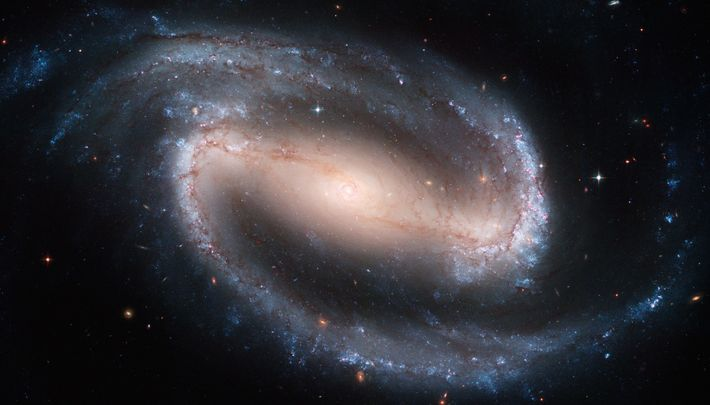

**Variables de desempeño (skills_ratings)**

**Retiramos arqueros y jugadores con bajo ranking**


In [85]:
n_acp=2000

df_acp=df.loc[:n_acp]
df_acp=df_acp[(df_acp["team_position"]!='GK')]
df_acp=df_acp[(df_acp["player_positions"]!='GK')]
df_acp=df_acp[df_acp['overall']>70]
df_acp.dropna(subset = ["team_position"], inplace=True)

skills_ratings = ['pace', 'shooting',
       'passing', 'dribbling', 'defending', 'physic', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed',
       'gk_positioning', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']

#otros skills_ratings ! sacamos las habilidades de los arqueros

In [86]:
df_acp.shape

(1751, 106)

Restringimos los datos a las variables numéricas que consideramos

In [87]:
X=df_acp[skills_ratings] # Datos para proyectar
print('los datos tienen dimesión n= ',len(skills_ratings))

los datos tienen dimesión n=  46


**Se computan las componentes principales**

-cuando se usa *decomposition.PCA* : 

La descomposición PCA del sklearn centra los datos pero no los Estandariza (input data is centered but not scaled for each feature before applying the SVD)

por eso **estandarizamos primero**

In [88]:
std_scale=preprocessing.StandardScaler().fit(X)
X_scaled=std_scale.transform(X) # numpyarray Estandarizado (le resta la media y divide por el desvío) por columna

In [89]:
print(X_scaled[0:2])

[[ 1.11904654  2.02974983  2.61446625  2.56874535 -1.29870002 -0.83765808
          nan         nan         nan         nan         nan         nan
   1.37634003  2.01843434  0.33712587  2.76955275  1.80944756  2.25960993
   1.86352992  2.23473279  2.35294919  3.02160514  1.55402924  0.67897256
   1.6021501   3.68443962  1.98126877  1.30093789 -0.17326584 -0.32622853
  -0.153544    1.97211898 -2.10853404 -1.02270755  1.7384736   2.27260321
   1.03578814  3.38678713         nan -1.28166999 -1.55894017 -1.44071021
   0.12752615  1.36017644  1.0720484  -0.77949398]
 [ 1.45914035  2.10470695  1.35377988  1.82690971 -1.46674374  0.64902758
          nan         nan         nan         nan         nan         nan
   1.30049036  2.01843434  1.94296752  1.15467201  1.68300215  1.44952071
   1.04089729  1.12456953  0.84564011  2.40678548  1.23128882  1.60377917
   1.26898127  3.88969076  0.09544877  2.08242672  2.06057353  0.95574527
   0.63617529  1.9039134  -0.59660829 -1.56397565  1.87701978

Pasamos los valores nan a ceros

In [90]:
X_scaled_not_nan = np.nan_to_num(X_scaled)

In [91]:
X_scaled_not_nan

array([[ 1.11904654,  2.02974983,  2.61446625, ...,  1.36017644,
         1.0720484 , -0.77949398],
       [ 1.45914035,  2.10470695,  1.35377988, ...,  1.36017644,
         1.0720484 ,  0.15943789],
       [ 0.52388237,  1.95479271,  0.97557397, ...,  0.42679867,
        -0.76860211, -0.1535394 ],
       ...,
       [ 0.52388237, -0.29392096,  0.59736806, ...,  1.04905051,
         1.37882348, -0.77949398],
       [-1.8567743 ,  0.45565026,  0.21916215, ..., -0.5065791 ,
        -0.46182703,  1.09836976],
       [ 1.5441638 ,  0.60556451, -1.29366148, ...,  0.73792459,
         1.37882348,  1.41134705]])

**DESCOMPOSICIÓN PCA**

En la descomposición podemos elegir n_components para quedarnos con una cantidad chica de componentes 

la idea es que sean "bastante" menos que la dimensión de lo datos pero 

que describan un buen porcentaje de la dispersión de los datos

In [96]:
pca=decomposition.PCA(n_components=10)

pca.fit(X_scaled_not_nan) #input data is centered but not scaled for each feature before applying the SVD

# proporción de varianza
print('proporción de varianza por componente: ', pca.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca.explained_variance_ratio_.cumsum())

X_projected=pca.transform(X_scaled_not_nan) #numpy array
print ('tamaño de los datos: ', X_projected.shape)


proporción de varianza por componente:  [0.38525003 0.12684589 0.09654439 0.06617695 0.03990827 0.03021754
 0.0237158  0.02317469 0.02225273 0.0214972 ]
proporción de varianza por componente acumulada:  [0.38525003 0.51209591 0.6086403  0.67481725 0.71472552 0.74494306
 0.76865886 0.79183355 0.81408629 0.83558349]
tamaño de los datos:  (1751, 10)


In [97]:
pca.explained_variance_ratio_[0:10].sum()

0.8355834888653162

In [94]:
import seaborn

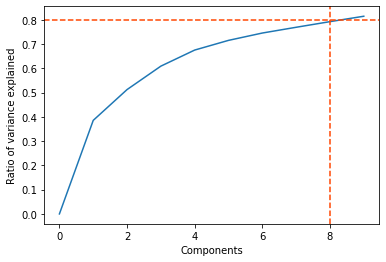

In [101]:
aux = []
for i in range(10):
    aux.append(pca.explained_variance_ratio_[0:i].sum())
    
fig, ax = plt.subplots(1)
seaborn.lineplot(x=range(pca.n_components),y=aux, ax=ax)
ax.axvline(8, color='orangered', linestyle='--')
ax.axhline(0.8, color='orangered', linestyle='--')

plt.ylabel("Ratio of variance explained")
plt.xlabel("Components")
fig.show()

Usamos 4 componentes que describen el 80% de la varianza

In [102]:
print (X_projected[0:5])#5 primeros jugadores, n_components

[[-9.78855216e+00 -2.68992445e+00  1.41401543e+00 -6.97761345e-01
  -1.34467440e+00  3.60640365e+00  1.43336019e+00 -8.20836408e-01
  -7.53379553e-01  6.32264646e-01]
 [-7.33877113e+00 -8.96007478e-01  3.31707531e+00 -4.33169457e+00
  -5.53058441e-01  3.15346149e+00  1.45737463e+00 -4.05358752e-01
  -3.30798206e-01 -8.27958112e-03]
 [-5.51028450e+00 -1.27544881e+00  4.14289720e+00 -3.27753187e+00
  -9.21998571e-01  1.38240424e+00 -2.41020389e-02  9.60489559e-01
   1.67015034e+00  1.42899027e+00]
 [-9.34616685e+00 -1.32207752e+00 -7.99425999e-02 -5.89099239e-01
  -3.95613684e-01  3.44880547e+00  1.43633347e+00  4.88349715e-02
   1.77153886e-01  7.50363297e-01]
 [-6.78468456e+00 -5.63299539e+00  1.79283481e+00 -1.40511937e+00
   1.09174603e-01  8.50973843e-01 -2.45901523e+00  9.40363378e-01
   1.48785611e-01  3.57542685e-01]]


In [103]:
df_acp["position2"]=df_acp["team_position"].apply(lambda x: pos2(x))

df_acp["position2"].value_counts()

delanteros        804
defensores        590
mediocampistas    357
Name: position2, dtype: int64

El siguiente gráfico muestra la composición de los pesos de las dos primeras componentes principales. 

In [104]:
bool_striker= df_acp["position2"] == 'delanteros'
bool_midfielder= df_acp["position2"] == 'mediocampistas'
bool_defender= df_acp["position2"] == 'defensores'
bool_gk= df_acp["position2"] == 'arqueros'

bool_crack=df_acp["overall"] > 85

palette=['navy','red','#A2D5F2','orange','green','pink']  
data=[]

striker =go.Scatter(x=X_projected[bool_striker,0], y=X_projected[bool_striker,1],name='delanteros',
                      text=df_acp.loc[bool_striker,'short_name'],
                      opacity=0.9,marker=dict(color=palette[2],size=5),mode='markers')

midfielder =go.Scatter(x=X_projected[bool_midfielder,0], y=X_projected[bool_midfielder,1],name='mediocampistas',
                      text=df_acp.loc[bool_midfielder,'short_name'],
                      opacity=0.6,marker=dict(color=palette[1],size=5),mode='markers')

defender =go.Scatter(x=X_projected[bool_defender,0], y=X_projected[bool_defender,1],name='defensores',
                      text=df_acp.loc[bool_defender,'short_name'],
                      opacity=0.7,marker=dict(color=palette[3],size=5),mode='markers')

gk =go.Scatter(x=X_projected[bool_gk,0], y=X_projected[bool_gk,1],name='arqueros',
                      text=df_acp.loc[bool_gk,'short_name'],
                      opacity=0.4,marker=dict(color=palette[4],size=5),mode='markers')

crack =go.Scatter(x=X_projected[bool_crack,0], y=X_projected[bool_crack,1],name='Top player',
                      text=df_acp.loc[bool_crack,'short_name'],textfont=dict(family='sans serif',color='black',size=16),
                      opacity=0.9,mode='text')

data=[striker,midfielder,defender,gk,crack]

layout = go.Layout(title="t-SNE - Fifa Players",titlefont=dict(size=20),
                autosize=False, width=1150,height=750)

fig = go.Figure(data=data, layout=layout)

#iplot(fig)
#plot(fig)

In [105]:
df[df["short_name"] == 'M. Sels']

sofifa_id                                         player_url short_name  \
564     199641  https://sofifa.com/player/199641/matz-sels/210002    M. Sels   

     long_name  age         dob  height_cm  weight_kg nationality  \
564  Matz Sels   28  1992-02-26        190         88     Belgium   

                club_name     league_name  league_rank  overall  potential  \
564  RC Strasbourg Alsace  French Ligue 1          1.0       79         81   

     value_eur  wage_eur player_positions preferred_foot  \
564   11000000     28000               GK          Right   

     international_reputation  weak_foot  skill_moves      work_rate  \
564                         1          2            1  Medium/Medium   

    body_type real_face  release_clause_eur player_tags team_position  \
564    Normal        No          22800000.0         NaN           RES   

     team_jersey_number loaned_from      joined  contract_valid_until  \
564                 1.0         NaN  2018-07-26                2024.0   

    nation_position  nation_jersey_number  pace  shooting  passing  dribbling  \
564             NaN                   NaN   NaN       NaN      NaN        NaN   

     defending  physic  gk_diving  gk_handling  gk_kicking  gk_reflexes  \
564        NaN     NaN       81.0         76.0        76.0         80.0   

     gk_speed  gk_positioning player_traits  attacking_crossing  \
564      36.0            79.0           NaN                  16   

     attacking_finishing  attacking_heading_accuracy  attacking_short_passing  \
564                   16                          14                       38   

     ...  movement_acceleration  movement_sprint_speed  movement_agility  \
564  ...                     37                     35                36   

     movement_reactions  movement_balance  power_shot_power  power_jumping  \
564                  75                34                57             70   

     power_stamina  power_strength  power_long_shots  mentality_aggression  \
564             30              67                18                    29   

     mentality_interceptions  mentality_positioning  mentality_vision  \
564                       17                     18                49   

     mentality_penalties  mentality_composure  defending_marking  \
564                   22                   62                NaN   

     defending_standing_tackle  defending_sliding_tackle  goalkeeping_diving  \
564                         15                        14                  81   

     goalkeeping_handling  goalkeeping_kicking  goalkeeping_positioning  \
564                    76                   76                       79   

     goalkeeping_reflexes    ls    st    rs    lw    lf    cf    rf    rw  \
564                    80  32+2  32+2  32+2  30+0  33+0  33+0  33+0  30+0   

      lam   cam   ram    lm   lcm    cm   rcm    rm   lwb   ldm   cdm   rdm  \
564  34+2  34+2  34+2  32+2  34+2  34+2  34+2  32+2  27+2  31+2  31+2  31+2   

      rwb    lb   lcb    cb   rcb    rb  
564  27+2  26+2  28+2  28+2  28+2  26+2  

[1 rows x 106 columns]

In [106]:
iplot(fig)

Podemos dividir a los jugadores con posición de defensores y atacantes, vemos que los mediocampistas hacen de interconexion entre las dos posiciones.

Se crea el jugador perfecto para ver a donde se ubica en nuestra visualización, se lo agrega a los datos normalizados y a las componentes ya calculadas (sin usarlo).

In [110]:
MachineGunDict={'short_name':'MachineGun','overall':99}
for skills in skills_ratings:
    MachineGunDict[skills]=99
    
#Lo agregamos a la base:
df_acp=df_acp.append(MachineGunDict,ignore_index=True)
X=df_acp[skills_ratings] # Datos sin estandarizar
X_scaled=std_scale.transform(X) # volvemos a estandarizar con el dato agregado 
X_scaled = np.nan_to_num(X_scaled)
#pero con la estandarización de la base sin el dato nuevo
X_projected=pca.transform(X_scaled) # volvemos a proyectar pero con el dato nuevo

**Graficamos a los jugadores usando las dos primeras componentes de PCA, proyectamos los datos (de dim 29) en ese espacio de dimensión 2**

Identificamos a MachineGun y a un jugador en particular, por ejemplo, Lio Messi: 

In [113]:
#Graph 2
#Choose your player
recherche_joueur=df_acp["short_name"]=='L. Messi'

bool_crack=df_acp["overall"] > 85
bool_no_crack=df_acp["overall"]<86
bool_machinegun=df_acp["short_name"]=='MachineGun'

palette=['navy','red','#A2D5F2','orange','green','pink']  
data=[]

acp_crack =go.Scatter(x=X_projected[bool_crack,0], y=X_projected[bool_crack,1],name='Crack',
                      text=df_acp.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=15,color='black'),
                      opacity=0.9,marker=dict(color=palette[2],size=7),mode='markers+text')

acp_no_crack =go.Scatter(x=X_projected[bool_no_crack,0], y=X_projected[bool_no_crack,1],name='Average player',
                         text=df_acp.loc[bool_no_crack,'short_name'],
                         opacity=0.6,marker=dict(color=palette[1],size=3),mode='markers')

acp_machinegun =go.Scatter(x=X_projected[bool_machinegun,0], y=X_projected[bool_machinegun,1],name='Perfect player',
                           textfont=dict(family='sans serif',size=20,color='black'),
                           opacity=0.6,marker=dict(color=palette[3],size=30),mode='markers+text')


joueur_recherche =go.Scatter(x=X_projected[recherche_joueur,0], y=X_projected[recherche_joueur,1],name='Searched player',
                           text=df_acp.loc[recherche_joueur,'short_name'],
                            textfont=dict(family='sans serif',size=20,color='black'),
                           opacity=1,marker=dict(color=palette[4],size=40),mode='markers+text')

data=[acp_no_crack,acp_crack,acp_machinegun,joueur_recherche]

layout = go.Layout(title="ACP - Fifa Players",titlefont=dict(size=20),
                xaxis=dict(title='Componente 1'),
                yaxis=dict(title='componente 2'),
                autosize=False, width=1000,height=750)

fig = go.Figure(data=data, layout=layout)

#plot(fig)

In [114]:
iplot(fig)

Mientras mas abajo a la izquierda esté el jugador, mejor overall va a tener

Se puede comparar dos equipos y ver los perfiles de los jugadores en las dos primeras componentes.

In [ ]:
df_acp.head()

In [118]:
teamA='Liverpool'
teamB='Manchester United'

bool_teamA=df_acp["club_name"]==teamA
bool_teamB=df_acp["club_name"]==teamB

palette=['navy','red','#A2D5F2','orange','green','pink','grey']  
data=[]

acp_teamA =go.Scatter(x=X_projected[bool_teamA,0], y=X_projected[bool_teamA,1],name=teamA,
                      text=df_acp.loc[bool_teamA,'short_name'],
                      textfont=dict(family='sans serif',size=20,color='black'),
                      opacity=0.7,marker=dict(color=palette[1],size=10),mode='markers+text')

acp_teamB =go.Scatter(x=X_projected[bool_teamB,0], y=X_projected[bool_teamB,1],name=teamB,
                      text=df_acp.loc[bool_teamB,'short_name'],
                      textfont=dict(family='sans serif',size=20,color='black'),
                      opacity=0.7,marker=dict(color=palette[4],size=10),mode='markers+text')

acp_all =go.Scatter(x=X_projected[:,0], y=X_projected[:,1],name='All',
                         text=df_acp.loc[:,'short_name'],
                         opacity=0.3,marker=dict(color=palette[6],size=3),mode='markers')


data=[acp_teamA,acp_teamB,acp_all]

layout = go.Layout(title="ACP - {} vs {}".format(teamA,teamB),titlefont=dict(size=20),
                xaxis=dict(title='F1'),
                yaxis=dict(title='F2'),
                autosize=False, width=1000,height=750)

fig = go.Figure(data=data, layout=layout)
#plot(fig)

In [119]:
iplot(fig)

In [120]:
df_acp.club_name.

0              FC Barcelona
1                  Juventus
2         FC Bayern München
3       Paris Saint-Germain
4           Manchester City
               ...         
1748        Nîmes Olympique
1749             CD Leganés
1750                Udinese
1751                    NaN
1752                    NaN
Name: club_name, Length: 1753, dtype: object

In [123]:
teamA='Liverpool'
teamB='Udinese'

bool_teamA=df_acp["club_name"]==teamA
bool_teamB=df_acp["club_name"]==teamB

palette=['navy','red','#A2D5F2','orange','green','pink','grey']  
data=[]

acp_teamA =go.Scatter(x=X_projected[bool_teamA,0], y=X_projected[bool_teamA,1],name=teamA,
                      text=df_acp.loc[bool_teamA,'short_name'],
                      textfont=dict(family='sans serif',size=20,color='black'),
                      opacity=0.7,marker=dict(color=palette[1],size=10),mode='markers+text')

acp_teamB =go.Scatter(x=X_projected[bool_teamB,0], y=X_projected[bool_teamB,1],name=teamB,
                      text=df_acp.loc[bool_teamB,'short_name'],
                      textfont=dict(family='sans serif',size=20,color='black'),
                      opacity=0.7,marker=dict(color=palette[4],size=10),mode='markers+text')

acp_all =go.Scatter(x=X_projected[:,0], y=X_projected[:,1],name='All',
                         text=df_acp.loc[:,'short_name'],
                         opacity=0.3,marker=dict(color=palette[6],size=3),mode='markers')


data=[acp_teamA,acp_teamB,acp_all]

layout = go.Layout(title="ACP - {} vs {}".format(teamA,teamB),titlefont=dict(size=20),
                xaxis=dict(title='F1'),
                yaxis=dict(title='F2'),
                autosize=False, width=1000,height=750)

fig = go.Figure(data=data, layout=layout)
#plot(fig)

In [124]:
iplot(fig)

Se puede llegar a comparar con dos equipos que mientras mas abajo en el grafico se encuentren mas cantidad de jugadores mejor va a ser el equipo.

# 5 .-Clustering

**Trabajo en grupo**: Veamos ahora que agrupamientos podemos hacer de los jugadores usando las dos/tres o cuatro primeras componentes. 

Presentar este ejercicio (con comentarios) pero con los datos FIFA2021 para el práctico entregable

k-medias y visualizar los clusters encontrados en las dos primeras componentes

In [125]:
X_projected

array([[-9.78855216e+00, -2.68992445e+00,  1.41401543e+00, ...,
        -8.20836408e-01, -7.53379553e-01,  6.32264646e-01],
       [-7.33877113e+00, -8.96007478e-01,  3.31707531e+00, ...,
        -4.05358752e-01, -3.30798206e-01, -8.27958112e-03],
       [-5.51028450e+00, -1.27544881e+00,  4.14289720e+00, ...,
         9.60489559e-01,  1.67015034e+00,  1.42899027e+00],
       ...,
       [-2.16245431e+00,  5.80349280e+00, -3.15324014e-01, ...,
         4.18549208e-02, -7.41299009e-01, -1.11593733e+00],
       [-8.63231495e+00, -9.72684412e+00,  3.11103393e+00, ...,
        -8.31734505e-01, -2.30184293e-02,  3.55961833e+00],
       [-8.63231495e+00, -9.72684412e+00,  3.11103393e+00, ...,
        -8.31734505e-01, -2.30184293e-02,  3.55961833e+00]])

In [126]:
from sklearn.cluster import KMeans,MeanShift

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

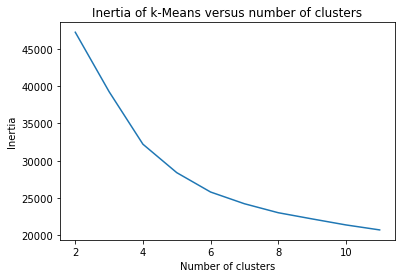

In [128]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(X_projected).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [129]:
# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust)
km.fit(X_projected) #utiliza todas las habilidades: 34 dimensiones

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  32217.798012971136


In [130]:
len(clusters)

1753

In [131]:
df_km = pd.DataFrame(X_projected)

In [132]:
df_km

0         1         2         3          4          5         6  \
0    -9.788552 -2.689924  1.414015 -0.697761  -1.344674   3.606404  1.433360   
1    -7.338771 -0.896007  3.317075 -4.331695  -0.553058   3.153461  1.457375   
2    -5.510285 -1.275449  4.142897 -3.277532  -0.921999   1.382404 -0.024102   
3    -9.346167 -1.322078 -0.079943 -0.589099  -0.395614   3.448805  1.436333   
4    -6.784685 -5.632995  1.792835 -1.405119   0.109175   0.850974 -2.459015   
...        ...       ...       ...       ...        ...        ...       ...   
1748 -2.403086  2.921192 -1.668156  2.788808   1.379238  -0.425828  0.585688   
1749  1.176802 -1.853392  2.739992  1.751888   0.572043   0.527072 -1.317317   
1750 -2.162454  5.803493 -0.315324 -0.696279   1.071872   1.946378  0.686755   
1751 -8.632315 -9.726844  3.111034 -9.705435  56.199162  24.101948 -2.060801   
1752 -8.632315 -9.726844  3.111034 -9.705435  56.199162  24.101948 -2.060801   

             7         8         9  
0    -0.820836 -0.753380  0.632265  
1    -0.405359 -0.330798 -0.008280  
2     0.960490  1.670150  1.428990  
3     0.048835  0.177154  0.750363  
4     0.940363  0.148786  0.357543  
...        ...       ...       ...  
1748 -0.540912  0.109025  1.588616  
1749 -0.398311  0.145877 -1.034647  
1750  0.041855 -0.741299 -1.115937  
1751 -0.831735 -0.023018  3.559618  
1752 -0.831735 -0.023018  3.559618  

[1753 rows x 10 columns]

In [133]:
df_km["cluster"] = clusters

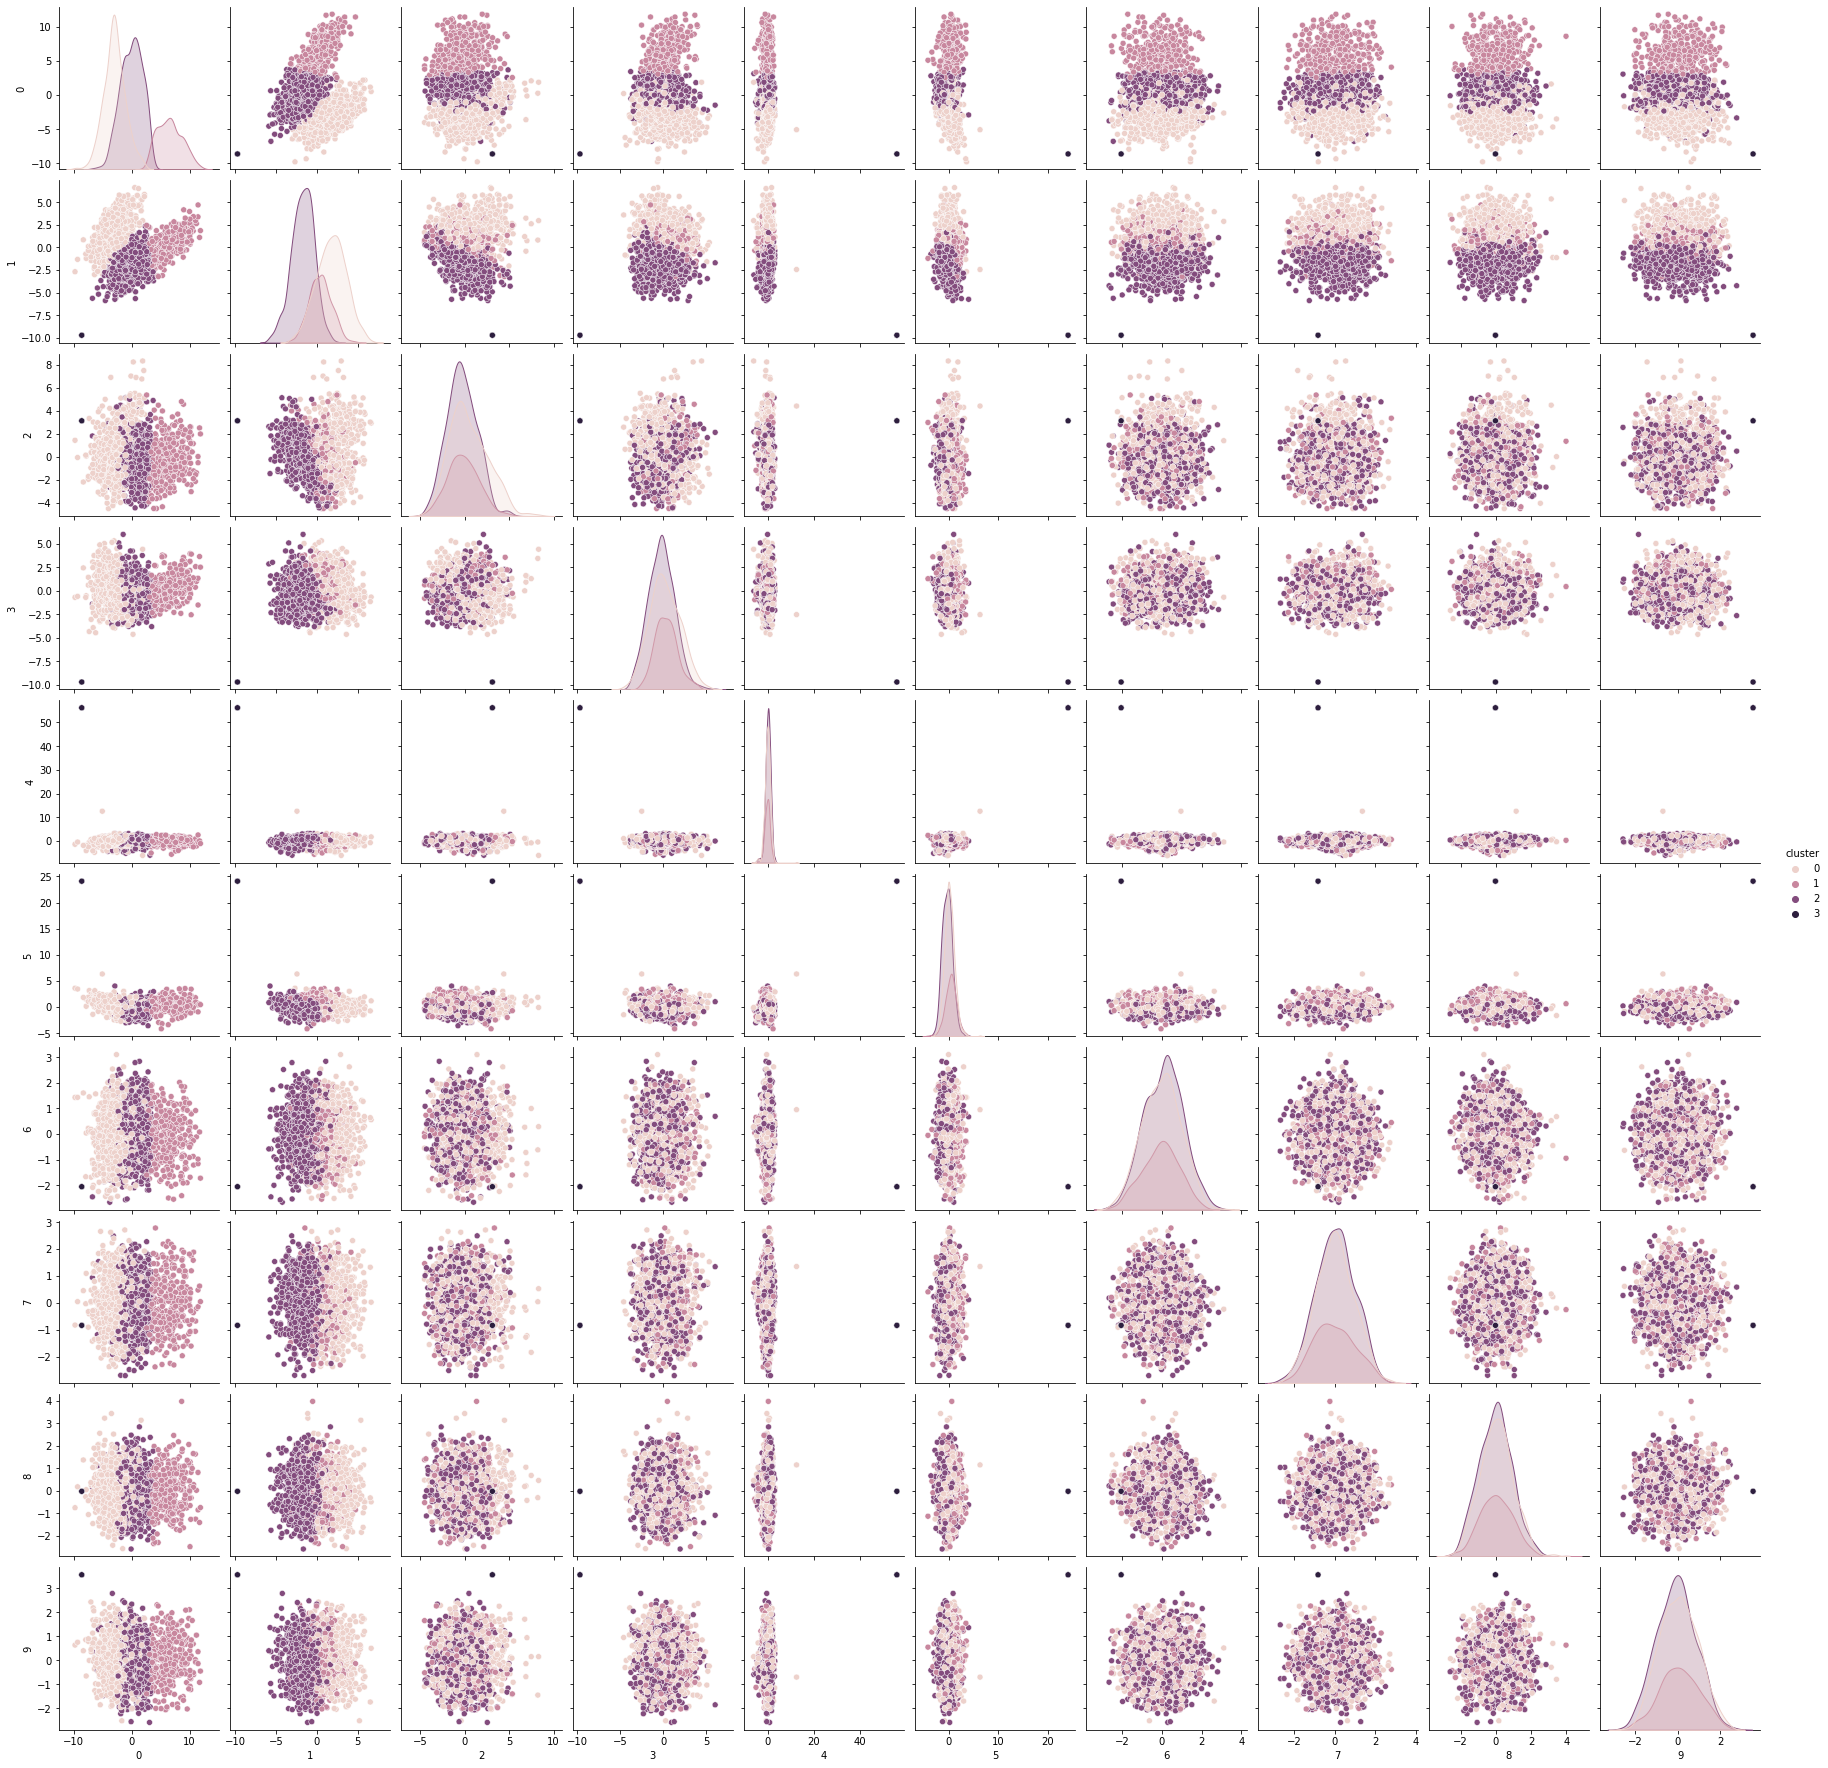

In [135]:
sns.pairplot(
    df_km,
    hue="cluster"
)

Vemos como sin arqueros se dividen en 3 cluster y no en 4. Kmeans fuerza a 4 cluster a pesar que encuentra 3 cluster y separa el cuarto por posible outliers.

In [137]:
df_km["cluster"].value_counts()

2    748
0    682
1    321
3      2
Name: cluster, dtype: int64

En el scatterplot podemos visualizar la separación realizada por k-means, se puede apreciar que hay un cluster muy similar al de arqueros.

Mean Shift y visualizar en las dos primeras componentes 

In [138]:
!pip install yellowbrick

     |████████████████████████████████| 271 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 14.9 MB 5.4 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3


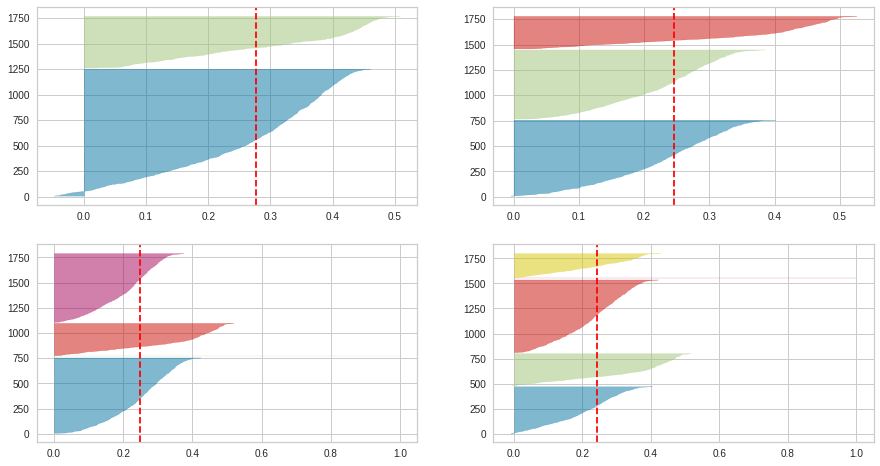

In [139]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_km)

Podemos ver en este gráfico de silueta que usando 3 cluster, los mismos se encuentran balanceados pero tiene el cluster rojo con un score alto y sin picos negativos.

In [142]:
pd.crosstab(df['player_positions'], df_km['cluster'])

cluster            0   1   2  3
player_positions               
CAM                3   4   6  0
CAM, CDM           1   0   0  0
CAM, CF            0   1   5  0
CAM, CF, RW        1   0   0  0
CAM, CF, ST        0   2   1  0
CAM, CM           11   2   9  0
CAM, CM, CDM       0   1   0  0
CAM, CM, CF        1   0   1  0
CAM, CM, LM        0   2   0  0
CAM, CM, LW        4   0   1  0
CAM, CM, RM        1   3   0  0
CAM, CM, ST        0   1   1  0
CAM, LM            2   1   0  0
CAM, LM, CM        1   1   0  0
CAM, LM, LW        2   0   0  0
CAM, LM, RM        0   0   1  0
CAM, LW            2   0   0  0
CAM, LW, CM        0   0   2  0
CAM, LW, ST        2   0   0  0
CAM, RM            3   3   6  1
CAM, RM, CF        1   0   1  0
CAM, RM, CM        0   1   2  0
CAM, RM, LM        2   0   0  0
CAM, RM, LW        0   0   1  0
CAM, RM, RW        0   1   0  0
CAM, RM, ST        0   0   1  0
CAM, RW            4   0   2  0
CAM, RW, RM        1   0   0  0
CAM, ST            2   3   0  0
CAM, ST, CF        0   0   1  0
CAM, ST, LM        0   0   1  0
CB                92  35  96  0
CB, CDM            7   4   9  0
CB, CDM, LB        0   1   0  0
CB, CM             1   1   0  0
CB, LB             3   0   8  0
CB, LB, RB         0   1   0  0
CB, RB             8   2   5  1
CB, RB, LB         0   1   0  0
CB, RB, RM         1   0   0  0
CB, RB, RWB        0   0   1  0
CDM                3   5  13  0
CDM, CAM, CM       1   0   0  0
CDM, CB            3   4   6  0
CDM, CB, CM        2   1   1  0
CDM, CB, LB        0   1   0  0
CDM, CM           53  21  49  0
CDM, CM, CAM       1   0   3  0
CDM, CM, CB        3   1   0  0
CDM, CM, LB        1   0   0  0
CDM, CM, LM        0   0   1  0
CDM, CM, RB        1   0   0  0
CDM, LB            0   1   0  0
CDM, RB            0   0   1  0
CDM, RWB           0   1   0  0
CF                 0   0   1  0
CF, CAM            1   0   1  0
CF, CAM, LW        0   1   1  0
CF, CAM, RW        0   0   1  0
CF, CAM, ST        0   0   1  0
CF, CM             1   0   0  0
CF, LM, CAM        1   0   0  0
CF, LM, LW         0   0   1  0
CF, LW, CAM        1   1   0  0
CF, LW, RW         0   0   1  0
CF, LW, ST         1   0   0  0
CF, RW             1   0   0  0
CF, ST             3   1   3  0
CF, ST, CAM        0   0   1  0
CF, ST, LM         0   1   0  0
CF, ST, LW         1   0   0  0
CF, ST, RW         0   0   1  0
CM                18  10  24  0
CM, CAM           11   2  11  0
CM, CAM, CDM       2   0   4  0
CM, CAM, LM        1   1   1  0
CM, CAM, LW        0   0   1  0
CM, CAM, RM        1   0   4  0
CM, CDM           24  14  23  0
CM, CDM, CAM       5   4   5  0
CM, CDM, CB        0   1   0  0
CM, CDM, LM        0   1   0  0
CM, CDM, RB        0   0   1  0
CM, CDM, RM        1   1   2  0
CM, CF             0   1   1  0
CM, CF, RM         1   0   1  0
CM, LM             2   0   1  0
CM, LM, CAM        0   1   0  0
CM, LM, CDM        0   0   1  0
CM, LM, LB         0   0   1  0
CM, LM, RM         1   0   1  0
CM, LW             1   0   0  0
CM, RB, LB         1   0   0  0
CM, RM             0   0   1  0
CM, RM, CAM        0   1   0  0
CM, RM, CDM        0   0   3  0
CM, RM, LM         0   0   1  0
CM, RW, CAM        0   0   1  0
CM, RW, LW         1   0   0  0
GK                81  28  76  0
LB                21   9  28  0
LB, CB             3   1   0  0
LB, CB, LM         0   0   1  0
LB, CB, LWB        0   0   1  0
LB, CM             1   0   0  0
LB, LM            11   2   9  0
LB, LM, CAM        1   0   0  0
LB, LM, LWB        0   1   1  0
LB, LM, RB         1   0   0  0
LB, LM, RM         0   0   1  0
LB, LWB            5   2   7  0
LB, LWB, LM        2   0   1  0
LB, RB             0   1   0  0
LB, RB, CB         1   0   0  0
LM                10   5  18  0
LM, CAM            2   0   2  0
LM, CAM, RM        0   1   1  0
LM, CF             2   1   2  0
LM, CM             1   1   2  0
LM, CM, CAM        0   0   1  0
LM, CM, RM         1   0   0  0
LM, LB             1   1   2  0
LM, LB, CM         1   0   0  0


In [141]:
pd.crosstab(df['team_position'], df_km['cluster']) 

cluster          0    1    2  3
team_position                  
CAM             19    9   23  0
CB               6    2   12  0
CDM             11    9   12  0
CF               1    0    1  0
CM               4    1    3  0
GK              66   17   53  0
LAM              2    2    1  0
LB              28   11   31  0
LCB             36   13   33  0
LCM             33    7   24  0
LDM             13    9   13  0
LF               1    2    1  0
LM              21   13   24  0
LS              20    5   17  0
LW              10    7   19  0
LWB              4    0    3  0
RAM              3    1    2  0
RB              27   12   39  0
RCB             38   14   35  0
RCM             26   10   27  0
RDM             11    9   19  0
RES             24   18   24  0
RF               0    0    2  0
RM              23    6   27  1
RS               9   13   16  0
RW              12    3   19  0
RWB              2    4    2  0
ST              32   14   31  0
SUB            184  101  221  1

In [143]:
df_ms = df_km.drop(["cluster"], axis=1)
df_ms

0         1         2         3          4          5         6  \
0    -9.788552 -2.689924  1.414015 -0.697761  -1.344674   3.606404  1.433360   
1    -7.338771 -0.896007  3.317075 -4.331695  -0.553058   3.153461  1.457375   
2    -5.510285 -1.275449  4.142897 -3.277532  -0.921999   1.382404 -0.024102   
3    -9.346167 -1.322078 -0.079943 -0.589099  -0.395614   3.448805  1.436333   
4    -6.784685 -5.632995  1.792835 -1.405119   0.109175   0.850974 -2.459015   
...        ...       ...       ...       ...        ...        ...       ...   
1748 -2.403086  2.921192 -1.668156  2.788808   1.379238  -0.425828  0.585688   
1749  1.176802 -1.853392  2.739992  1.751888   0.572043   0.527072 -1.317317   
1750 -2.162454  5.803493 -0.315324 -0.696279   1.071872   1.946378  0.686755   
1751 -8.632315 -9.726844  3.111034 -9.705435  56.199162  24.101948 -2.060801   
1752 -8.632315 -9.726844  3.111034 -9.705435  56.199162  24.101948 -2.060801   

             7         8         9  
0    -0.820836 -0.753380  0.632265  
1    -0.405359 -0.330798 -0.008280  
2     0.960490  1.670150  1.428990  
3     0.048835  0.177154  0.750363  
4     0.940363  0.148786  0.357543  
...        ...       ...       ...  
1748 -0.540912  0.109025  1.588616  
1749 -0.398311  0.145877 -1.034647  
1750  0.041855 -0.741299 -1.115937  
1751 -0.831735 -0.023018  3.559618  
1752 -0.831735 -0.023018  3.559618  

[1753 rows x 10 columns]

In [147]:
ms = MeanShift(bandwidth=5)

ms.fit(df_ms)

clusters_ms = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters_ms)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

Cantidad de clusters encontrados por Mean Shift : 4


In [150]:
def search_ms_optimus(data_clus, bandwidth):
    sse ={}
    for bw in bandwidth:
        clusterer = MeanShift(bandwidth=bw)
        print("Start fitting")
        cluster_labels = clusterer.fit_predict(data_clus)
        print("Stop fitting")
        #sse[n_clusters] = clusterer.inertia_

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(data_clus, cluster_labels, random_state=352)
        print("Para bamdwith =", bw,
              "El silhouette_score promedio es :", silhouette_avg)
        print (" Para bandwidth =", bw, "La cantidad de clusters encontrados es: ", len(np.unique(clusterer.labels_)))

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data_clus, cluster_labels)

        plot_silouette(sample_silhouette_values, cluster_labels,
                       silhouette_avg, title="bw={}".format(bw))
    return sse

In [151]:
def plot_silouette(silhouette_values, cluster_labels, silhouette_avg, 
                   title="Visualizacion de los datos"):
    fig, ax1 = plt.subplots(1, 1)
    y_lower = 10
    n_clusters = len(np.unique(cluster_labels))
    for i in np.unique(cluster_labels):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color   = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(title)
    # ax1.set_xlabel("espacio de la primera caracteristica")
    # ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

In [153]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

Start fitting
Stop fitting
Para bamdwith = 5 El silhouette_score promedio es : 0.29863734205032905
 Para bandwidth = 5 La cantidad de clusters encontrados es:  4


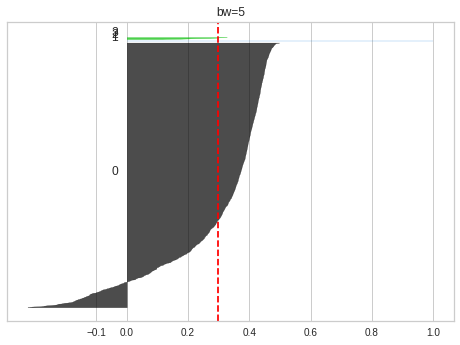

Start fitting
Stop fitting
Para bamdwith = 10 El silhouette_score promedio es : 0.5525497949627292
 Para bandwidth = 10 La cantidad de clusters encontrados es:  3


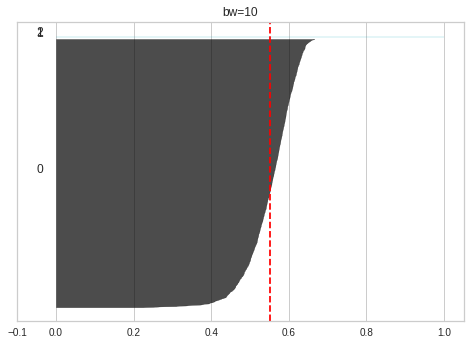

Start fitting
Stop fitting
Para bamdwith = 25 El silhouette_score promedio es : 0.8806664889269024
 Para bandwidth = 25 La cantidad de clusters encontrados es:  2


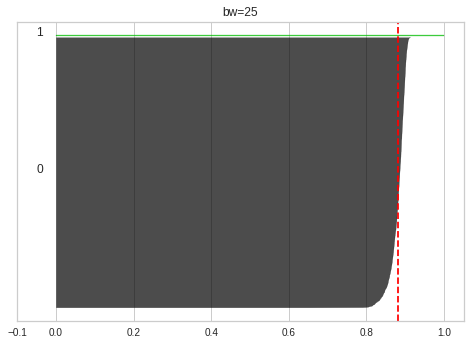

{}

In [155]:
bandwidth = [5, 10, 25]
search_ms_optimus(df_ms,bandwidth)

In [156]:
clusters_ms

array([0, 0, 0, ..., 0, 1, 1])

In [158]:
data=[]
bool_crack=df_acp["overall"] > 85
bool_no_crack=df_acp["overall"]<86

kmean_clusters = go.Scatter(x=X_projected[:,0], y=X_projected[:,1],
                           mode='markers',
                        text=df_acp.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters_ms.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

acp_crack =go.Scatter(x=X_projected[bool_crack,0], y=X_projected[bool_crack,1],name='Top players',
                      text=df_acp.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,acp_crack]

layout = go.Layout(title="ACP + Clustering Mean Shift ",titlefont=dict(size=20),
                xaxis=dict(title='Componente 1'),
                yaxis=dict(title='Componente 2'),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

Meanshift no divide correctamente los cluster, pone a la mayoria de los jugadores en uno solo.